In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt

from torch import nn
from torch.utils.data import TensorDataset, DataLoader

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.models import vgg16, vgg16_bn, resnet18, resnet34, resnet50, resnet101, resnet152

from sklearn.model_selection import train_test_split
import sklearn.metrics as skm
from sklearn.metrics import f1_score

import seaborn as sn

from os import listdir, path
from PIL import Image
from collections import defaultdict
import csv
import re

from IPython.display import display, clear_output, Image as IPython_Image

In [2]:
torch.cuda.is_available()

True

# Data loading

In [3]:
IMAGE_PATH = '../data/images'
LABEL_PATH = '../data/annotations'

# GIVEN DATASET
MEAN = (0.43672, 0.40107, 0.36762)
STD = (0.30139, 0.28781, 0.29236)

# IMAGENET
#MEAN = (0.485, 0.456, 0.406)
#STD = (0.229, 0.224, 0.225)

# RESNET
#MEAN = (0.485, 0.456, 0.406)
#STD = (0.229, 0.224, 0.225)
       
# Define default pos_weights for nn.BCEWithLogitsLoss(pos_weights). If the get_dataloader() is run, is will 
# overwrite this variable based on the statistics of the test set.
label_pos_weights_for_loss = np.array([209.52631579, 55.87203791, 58.40594059, 16.77777778, 44.80152672, 5.25, 25.14379085, 5.75675676, 33.09090909, 2.15540363, 5.51465798, 163.38356164, 119., 37.46153846], dtype=np.float32)

In [4]:
def number_of_classes():
    return len(listdir(LABEL_PATH))

In [5]:
def get_class_map():
    ret = {}

    i = 0
    for fname in listdir(LABEL_PATH):
        img_class, _ = fname.split('.')
        ret[img_class] = i
        i += 1

    return ret

In [6]:
def write_labels_to_csv(name_of_set, label_array):
    filepath = f'../data/labels_{name_of_set}.csv'
    
    label_arr = np.array(label_array).astype(int)

    # Save 2D numpy array to csv file
    np.savetxt(filepath, label_arr, delimiter=',', fmt='%d')

In [7]:
def calculate_label_statistics(label_array, total_n_images):
    label_arr = np.array(label_array).astype(int)
    pos_label_counts_all = np.sum(label_arr, axis=0)
    neg_label_counts_all = total_n_images - pos_label_counts_all
    relative_label_occurrances =  pos_label_counts_all/total_n_images
    pos_weights = neg_label_counts_all / pos_label_counts_all
    
    return pos_weights, pos_label_counts_all, neg_label_counts_all, relative_label_occurrances

In [8]:
def print_label_statistics(name_of_set, pos_weights, pos_label_counts_all, neg_label_counts_all, relative_label_occurrances):    
    print(f'\nData set: {name_of_set}')
    print(' Positive label counts\n  ', pos_label_counts_all)
    print(' Negative label counts\n  ', neg_label_counts_all)
    print(' Relative label occurrances\n  ', relative_label_occurrances)
    print(' Pos_weights\n  ', pos_weights)

In [9]:
n_image_files = len([name for name in listdir(IMAGE_PATH) if path.isfile(path.join(IMAGE_PATH, name))])

indices = np.arange(n_image_files)
print(indices)

[    0     1     2 ... 19997 19998 19999]


In [68]:
def get_dataloader(bs=256, train_fr=.6, max_images_per_class=1e9, use_no_label_imgs = True, transformations=None):
    
    tensor_transformation = transforms.Compose([transforms.ToTensor()])
    pil_transformation = transforms.Compose([transforms.ToPILImage()])
    
    # mapping from class names to integers
    class_map = get_class_map()

    # create a dictionary to hold our label vectors
    n_classes = len(class_map.keys())
    img_to_class = defaultdict(lambda: np.zeros(n_classes))

    # another dictionary to hold the actual image data
    img_to_data = dict()
    
    # loop through all the annotations
    for fname in listdir(LABEL_PATH):
        img_class, _ = fname.split('.')
        print(f'Reading class: {img_class}')
        
        # open the annotation file
        with open(f'{LABEL_PATH}/{fname}', 'r') as fh:

            # get image ids from annotation file
            img_ids = fh.read().splitlines()
            
            # gather the images with labels
            for i, img_id in enumerate(img_ids):
                
                # let's not process images unnecessarily
                if not img_id in img_to_data:

                    img_path = f'{IMAGE_PATH}/im{img_id}.jpg'
                    img = Image.open(img_path)

                    # append to dict
                    img_to_data[img_id] = tensor_transformation(img.convert('RGB'))

                # get one-hot encoded vector of image classes
                img_classes = img_to_class[img_id]

                # add new class to image vector
                img_class_id = class_map[img_class]
                img_classes[img_class_id] = 1

                # store the updated vector back
                img_to_class[img_id] = img_classes

                if i >= max_images_per_class-1:
                    break

    # If use_no_label_imgs is on, load also all the images that do not have any labels
    if (use_no_label_imgs):
        i = 0
        for fname in listdir(IMAGE_PATH):
            m = re.match('im(\d+)', fname)
            img_id = m.group(1)

            if img_id not in img_to_data:
                img_path = f'{IMAGE_PATH}/im{img_id}.jpg'
                img = Image.open(img_path)

                # append to dict
                img_to_data[img_id] = tensor_transformation(img.convert('RGB'))

                if i >= max_images_per_class:
                    break
                i += 1
 
    # collect data to a single array
    X = []
    y = []
    for img_id in img_to_data.keys():
        X.append(img_to_data[img_id])
        y.append(img_to_class[img_id])

    X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, train_size=train_fr, random_state=42)
    X_test, X_valid, y_test, y_valid = train_test_split(X_tmp, y_tmp, train_size=.5, test_size=.5, random_state=42)
    
    def apply_transformations_to_image(imag, trans):
        imag_PIL = pil_transformation(imag)
        return trans(imag_PIL).numpy()
       
    # Apply per-set transformations for images
    for i, imag in enumerate(X_train):
        X_train[i] = apply_transformations_to_image(imag, transformations['train'])    
    for i, imag in enumerate(X_valid):
         X_valid[i] = apply_transformations_to_image(imag, transformations['valid'])
    for i, imag in enumerate(X_test):
         X_test[i] = apply_transformations_to_image(imag, transformations['test'])    
       
    # Write labels to csv file
    #write_labels_to_csv('all', y)
    #write_labels_to_csv('train', y_train)
    #write_labels_to_csv('validation', y_valid)
    #write_labels_to_csv('test', y_test)
    
    # Calculate and print out label statistics to be able to analyze label imbalance
    pos_weights_all, pos_label_counts_all, neg_label_counts_all, relative_label_occurrances_all = calculate_label_statistics(y, len(X))
    pos_weights_train, pos_label_counts_train, neg_label_counts_train, relative_label_occurrances_train = calculate_label_statistics(y_train, len(X_train))
    pos_weights_valid, pos_label_counts_valid, neg_label_counts_valid, relative_label_occurrances_valid = calculate_label_statistics(y_valid, len(X_valid))
    pos_weights_test, pos_label_counts_test, neg_label_counts_test, relative_label_occurrances_test = calculate_label_statistics(y_test, len(X_test))
    
    print_label_statistics('all', pos_weights_all, pos_label_counts_all, neg_label_counts_all, relative_label_occurrances_all)
    print_label_statistics('train', pos_weights_train, pos_label_counts_train, neg_label_counts_train, relative_label_occurrances_train)
    print_label_statistics('validation', pos_weights_valid, pos_label_counts_valid, neg_label_counts_valid, relative_label_occurrances_valid)
    print_label_statistics('test', pos_weights_test, pos_label_counts_test, neg_label_counts_test, relative_label_occurrances_test)
    
    # Set the pos_weights to be used in the loss function
    label_pos_weights_for_loss = pos_weights_train
    
    train_dataloader = DataLoader(TensorDataset(
        torch.tensor(X_train, dtype=torch.float),
        torch.tensor(y_train, dtype=torch.float)),
        shuffle=True,
        batch_size=bs)           

    valid_dataloader = DataLoader(TensorDataset(
        torch.tensor(X_valid, dtype=torch.float),
        torch.tensor(y_valid, dtype=torch.float)),
        shuffle=True,
        batch_size=bs)

    test_dataloader = DataLoader(TensorDataset(
        torch.tensor(X_test, dtype=torch.float),
        torch.tensor(y_test, dtype=torch.float)),
        shuffle=True,
        batch_size=bs)      

    return train_dataloader, valid_dataloader, test_dataloader

# Models

In [11]:
class TwoLayerModel(nn.Module):
    def __init__(self, n_input, n_hidden1, n_hidden2, n_classes):
        super().__init__()
        self.bs = bs
        self.input_layer = nn.Linear(n_input, n_hidden1)
        self.hidden1 = nn.Linear(n_hidden1, n_hidden2)
        self.hidden2 = nn.Linear(n_hidden2, n_classes)
        self.relu = nn.ReLU()
        self.bn0 = nn.BatchNorm1d(n_input)
        self.bn1 = nn.BatchNorm1d(n_hidden1)
        self.bn2 = nn.BatchNorm1d(n_hidden2)

    def forward(self, x):
        x = self.bn0(x)
        x = self.input_layer(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = self.hidden1(x)
        x = self.relu(x)
        x = self.bn2(x)
        x = self.hidden2(x)

        return x

In [12]:
class OneLayerModel(nn.Module):
    def __init__(self, n_input, n_hidden, n_classes):
        super().__init__()

        self.input_layer = nn.Linear(n_input, n_hidden)
        self.hidden = nn.Linear(n_hidden, n_classes)
        self.relu = nn.ReLU()
        self.bn0 = nn.BatchNorm1d(n_input)
        self.bn1 = nn.BatchNorm1d(n_hidden)

    def forward(self, x):
        print(f'X.SHAPE: {x.shape}')
        x = self.bn0(x)
        x = self.input_layer(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = self.hidden(x)

        return x

In [13]:
class ConvNetModel(nn.Module):
    def __init__(self, n_classes, keep_prob=.5):
        super(ConvNetModel, self).__init__()
        # Common layers used multiple times
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=1-keep_prob)
        
        # Unique layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=256, kernel_size=3, stride=1, padding=1) #(n samples, channels, height, width)
        self.conv2 = nn.Conv2d(in_channels=256, out_channels=14, kernel_size=3, stride=1, padding=1)
        self.fc3 = nn.Linear(in_features=256*4*14, out_features=n_classes)
        
    def forward(self, x):
        x = x.reshape(-1, 3, 128, 128)
        
        out = self.conv1(x)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.dropout(out)
        
        out = self.conv2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.dropout(out)
        
        out = out.reshape(out.size(0), -1)  # Flatten for FC
        out = self.fc3(out)
        return out    

# Training and evaluation functions

In [14]:
def evaluate(dataloader, model, criterion, device, threshold=0.5):
    model.eval()

    f1_scores = []
    losses = []

    with torch.no_grad():
        for batch in dataloader:
            X, y = batch
            X = X.to(device)
            y = y.to(device)
            y_pred = model(X)

            loss = criterion(y_pred, y)
            losses.append(loss)

            with torch.no_grad():
                score = f1_score(y.cpu() == 1, y_pred.cpu() > threshold, average='micro')
                f1_scores.append(score)

    model.train()

    return torch.mean(torch.tensor(losses)), torch.mean(torch.tensor(f1_scores))

In [15]:
def train(train_dataloader, valid_dataloader, model, optimizer, scheduler, criterion, device, n_epochs=50, verbose=True):
    model.train()

    if verbose:
        fmt = '{:<5} {:12} {:12} {:<9} {:<9}'
        print(fmt.format('Epoch', 'Train loss', 'Valid loss', 'Train F1', 'Valid F1'))

    for epoch in range(n_epochs):
        
        for i, batch in enumerate(train_dataloader):
            X, y = batch
            
            X = X.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            y_pred = model(X)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            print(f'Epoch: {epoch+1}, iteration: {i+1}, loss: {loss}')

        if verbose:
            train_loss, train_score = evaluate(train_dataloader, model, criterion, device)
            valid_loss, valid_score = evaluate(valid_dataloader, model, criterion, device)

            fmt = '{:<5} {:03.10f} {:03.10f} {:02.7f} {:02.7f}'
            print(fmt.format(epoch, train_loss, valid_loss, train_score, valid_score))
            
    print('Done training!')

In [33]:
def visualize_predictions(model, device, dataloader, mean=MEAN, std=STD, n_to_show=3, threshold=0.5):
    
    class_to_label = { v: k for k, v in get_class_map().items() }
    
    # https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821/5
    inv_transform = transforms.Compose([
        transforms.Normalize(mean = -1 * np.multiply(mean, std), std=np.divide(1, std))
    ])
    
    n_shown = 0
    for i, batch in enumerate(dataloader):        
        X, y = batch
        X = X.to(device)

        y_pred_raw = model(X).cpu()
        y_pred = y_pred_raw > threshold 
        y = y == 1

        for i in range(len(y)):
            pred_classes = np.where(y_pred[i] == 1)[0]
            true_classes = np.where(y[i] == 1)[0]
            
            true_classes_str = ', '.join([class_to_label[i] for i in true_classes])
            pred_classes_str = ', '.join([class_to_label[i] for i in pred_classes])

            img = inv_transform(X[i].cpu())              # inverse transforms
            img = img.permute(2, 1, 0)                   # BGR -> RGB
            img = np.rot90(img, 3)
                                    
            plt.title(f'True: {true_classes_str}, Predictions: {pred_classes_str}')
            plt.imshow(img)
            plt.pause(0.001)

            n_shown += 1
            
            if n_shown >= n_to_show:
                return            

It would be nice to use same naming conventions everywhere. Might be a good idea to rename `y_hat` to `y_pred` or vice versa everywhere (it makes it easier to combine the notebooks). I don't care which way it is. Also the `Xs` and `ys` etc.

In [17]:
def predict_X(fr, threshold=0.5):
    
    y_hat = fr > threshold
    
    return y_hat if (np.sum(y_hat) > 0) else fr == np.max(fr)

def predict(model, device, dataloader):
    
    ys_all = []  # Array of np.array(14) 
    y_hats_all = []
    
    for i, batch in enumerate(dataloader):
        
        Xs, ys = batch
        Xs = model(Xs.to(device))
        y_hats = np.apply_along_axis(predict_X, axis=1, arr=Xs.cpu().detach().numpy())
        
        y_hats_all.extend(y_hat for y_hat in y_hats)
        ys_all.extend(y.numpy() for y in ys==1)

    return np.array(ys_all), np.array(y_hats_all)

def visualize_confusion_matrix(y_true, y_pred, labels, file_path):

    plt.ioff()
    
    # Get confusion matrices
    cn_tensor = skm.multilabel_confusion_matrix(y_true, y_pred)
    
    # Get precision, recall, f1-score
    scores = skm.classification_report(y_true, y_pred, output_dict=True)

    fig, ax = plt.subplots(nrows=5, ncols=3,sharey=True, figsize=(20, 20), 
                           gridspec_kw={'hspace': 0.3, 'wspace': 0.0})
    gn = ['True Neg','False Pos','False Neg','True Pos']
    n = cn_tensor[0].sum()
    
    # Loop all labels
    for i, cn_matrix in enumerate(cn_tensor):

        j, k = int(i/3), i%3
        
        # Annotations
        annot = np.asarray(
            ['{}\n{:0.0f}\n{:.2%}'.format(gn[i], x, x/n) for i, x in enumerate(cn_matrix.flatten())]
        ).reshape(2,2)
        
        # Plot heatmap
        sn.heatmap(cn_matrix, annot=annot, fmt='', cmap='Blues', ax=ax[j, k])
        
        # Precision, recall, f1-score
        title = '{}\nprec.={:.3}, rec.={:.3}, f1={:.3}'.format(
            labels[i], scores[str(i)]['precision'], scores[str(i)]['recall'], scores[str(i)]['f1-score'])
        ax[j, k].set_title(title)
        
    plt.savefig(file_path, bbox_inches='tight')
    plt.close()

# Do the magic!

In [18]:
if torch.cuda.is_available():
    print('Using GPU!')
    device = torch.device('cuda')
else:
    print('Using CPU')
    device = torch.device('cpu')

lr = 0.01
n_epochs = 20
bs = 64
n_classes = len(get_class_map().keys())

Using GPU!


## Create and save / load dataloaders from disk

If you want to test the models that do not seem to work with 128x128 images change the transformation to do the resize.

However, it should be investigated if, for example RESNET, can be made to work with 128x128 images.

In [70]:
use_no_label_imgs = True
max_images_per_class = 1e9
#max_images_per_class = 200
affix = "_" + str(max_images_per_class) if max_images_per_class < 1e9 else ""

# Data augmentation / Mikko 17.5..
# - Apply some transformations with p=0.5
# - Let's not crop: cropping could remove some of the labeled objects
# - Random erasing is kind of the same. Could only erase very small regions not to lose important parts 
# possibly containing the label. transforms.RandomErasing(p=0.3, scale=(0.02, 0.06), ratio=(1, 3), value=0, inplace=False),

transformations = {
    'train':
        transforms.Compose([
        transforms.RandomApply([
            transforms.RandomHorizontalFlip(p=1),
            transforms.RandomRotation((-10, 10)),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3),
            transforms.RandomGrayscale(p=1),
            transforms.RandomPerspective(),
        ], p=1),
        transforms.ToTensor(),                
        transforms.Normalize(mean=MEAN, std=STD)            
    ]),
    'valid': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN, std=STD)
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN, std=STD)
    ]),
}

try:
    train_dataloader = torch.load(f'../data/train_dataloader{affix}.dat')
    valid_dataloader = torch.load(f'../data/valid_dataloader{affix}.dat')
    test_dataloader = torch.load(f'../data/test_dataloader{affix}.dat')
except:
    train_dataloader, valid_dataloader, test_dataloader = get_dataloader(
        bs=bs, 
        transformations = transformations,
        max_images_per_class=max_images_per_class,
        use_no_label_imgs=use_no_label_imgs
    )
    torch.save(train_dataloader, f'../data/train_dataloader{affix}.dat')
    torch.save(valid_dataloader, f'../data/valid_dataloader{affix}.dat')
    torch.save(test_dataloader, f'../data/test_dataloader{affix}.dat')

Reading class: river
Reading class: clouds
Reading class: baby
Reading class: car
Reading class: dog
Reading class: bird
Reading class: flower
Reading class: male
Reading class: portrait
Reading class: tree
Reading class: night
Reading class: female
Reading class: people
Reading class: sea
[[[-1.4490197 -1.4490197 -1.4490197 ... -1.3579384 -1.4490197 -1.4490197]
  [-1.4490197 -1.4490197 -1.4490197 ... -1.3579384 -1.4490197 -1.4490197]
  [-1.4229964 -1.4099848 -1.4099848 ... -1.37095   -1.4490197 -1.4490197]
  ...
  [-1.4490197 -1.4490197 -1.4490197 ... -1.1887875 -1.2408339 -1.2538455]
  [-1.4490197 -1.4490197 -1.4490197 ... -1.4490197 -1.4490197 -1.4490197]
  [-1.4490197 -1.4490197 -1.4490197 ... -1.4490197 -1.4490197 -1.4490197]]

 [[-1.3935235 -1.3935235 -1.3935235 ... -1.2981447 -1.3935235 -1.3935235]
  [-1.3935235 -1.3935235 -1.3935235 ... -1.2981447 -1.3935235 -1.3935235]
  [-1.3662724 -1.3526468 -1.3526468 ... -1.3117702 -1.3935235 -1.3935235]
  ...
  [-1.3935235 -1.3935235 -1.3

## Pretrained models

NB: The mean and std in transformations most probably need to be the same as for VGG and RESNET. Not 100% sure about this. Something to investigate!

More models here: https://pytorch.org/docs/stable/torchvision/models.html

If the models do not start to converge, try lowering the learning rate!

_VGG16_

Currently getting validation f1 scores around 0.67.

Surprisingly after quick testing the vgg16_bn (with BatchNorm layers) did not do as well? Maybe more to investigate here.

In [20]:
if False:
    model = vgg16(pretrained=True).to(device)

    for param in model.parameters():
        param.requires_grad = False

    model.classifier = nn.Sequential(
        # PyTorch 1.4.0 and related libraries
        # seem to produce 8192 output to fc?
        # Don't know why.
        #nn.Linear(8192, 4096),
        
        # This is for recent PyTorch
        nn.Linear(25088, 4096),
        nn.ReLU(),
        nn.Linear(4096, 2048),
        nn.ReLU(),
        nn.Linear(2048, 14),
    ).to(device)

_RESNET_


In [21]:
if False:
    model = resnet18(pretrained=True).to(device)

    #for layer in model.children():
    #    layer.requires_grad = False

    model.fc = nn.Linear(512, 14).to(device)

In [22]:
if False:
    model = resnet34(pretrained=True).to(device)

    for layer in model.children():
        layer.requires_grad = False

    model.fc = nn.Linear(512, 14).to(device)

In [23]:
if False:
    model = resnet50(pretrained=True).to(device)

    for layer in model.children():
        layer.requires_grad = False

    model.fc = nn.Linear(2048, 14).to(device)

In [71]:
if True:
    model = resnet101(pretrained=True).to(device)

    for layer in model.children():
        layer.requires_grad = False

    model.fc = nn.Linear(2048, 14).to(device)

In [25]:
if False:
    model = resnet152(pretrained=True).to(device)

    for layer in model.children():
        layer.requires_grad = False

    model.fc = nn.Linear(2048, 14).to(device)

## Train a model or load an existing model from disk

In [74]:
n_epochs = 10

In [75]:
#model_path = '../data/TwoLayerModel_state.dict'
#model_path = f'../data/ConvNetModel_state{affix}.dict'

#model = OneLayerModel(224*224*3, 256, n_classes).to(device)
#model = TwoLayerModel(128*128*3, 512, 256, n_classes).to(device)
#model = ConvNetModel(n_classes=n_classes, keep_prob=.5).to(device)

# loss function
pos_weight = torch.from_numpy(label_pos_weights_for_loss).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# optimizer
#optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
#optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

# learning rate and momentum will be overriden by the scheduler
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# scheduler
#scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.00001, max_lr=0.1)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.0001,
    base_momentum=0.5,
    max_momentum=0.99,
    steps_per_epoch=len(train_dataloader),
    epochs=n_epochs,
)

In [52]:
# Paths for model saving and loading

# Only state dictionary
#model_save_path = '../data/resnet-valid-acc-aug-0.70.pth'
#model_save_path = '../data/resnet-101-valid-acc-0.73.pth'
model_save_path = '../data/resnet-valid-acc-aug-0.716.pth'
#model_save_path = '../data/vgg16-9epochs-valid-acc-0.66.pth'

# Whole model
#model_whole_save_path = '../data/vgg16-7epochs-valid-acc-0.703.pth'

In [72]:
# Plain model saving and loading (only state dictionary).
#torch.save(model.state_dict(), model_save_path)
model.load_state_dict(torch.load(model_save_path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [30]:
# Save an entire model (not just the state dict)
#torch.save(model, model_whole_save_path)

In [31]:
# Load an entire model (not just the state dict)
#model = torch.load(model_whole_save_path)
#model.eval()

In [32]:
asdf

NameError: name 'asdf' is not defined

In [73]:
# This is for trying to train all the layers...
for param in model.parameters():
    param.requires_grad = True

In [76]:
%time train(train_dataloader, valid_dataloader, model, optimizer, scheduler, criterion, device, n_epochs=n_epochs)

Epoch Train loss   Valid loss   Train F1  Valid F1 
Epoch: 1, iteration: 1, loss: 0.8260785937309265
Epoch: 1, iteration: 2, loss: 2.124699354171753
Epoch: 1, iteration: 3, loss: 0.6826601624488831
Epoch: 1, iteration: 4, loss: 2.8228583335876465
Epoch: 1, iteration: 5, loss: 2.834709405899048
Epoch: 1, iteration: 6, loss: 2.195563793182373
Epoch: 1, iteration: 7, loss: 8.621672630310059
Epoch: 1, iteration: 8, loss: 1.8035377264022827
Epoch: 1, iteration: 9, loss: 2.5265774726867676
Epoch: 1, iteration: 10, loss: 2.9222569465637207
Epoch: 1, iteration: 11, loss: 4.477834701538086
Epoch: 1, iteration: 12, loss: 1.2462420463562012
Epoch: 1, iteration: 13, loss: 3.620161771774292
Epoch: 1, iteration: 14, loss: 2.7780752182006836
Epoch: 1, iteration: 15, loss: 3.7486562728881836
Epoch: 1, iteration: 16, loss: 3.4969494342803955
Epoch: 1, iteration: 17, loss: 4.31387996673584
Epoch: 1, iteration: 18, loss: 2.767367362976074
Epoch: 1, iteration: 19, loss: 3.013643741607666
Epoch: 1, iterati

Epoch: 1, iteration: 164, loss: 2.2149531841278076
Epoch: 1, iteration: 165, loss: 0.7355232834815979
Epoch: 1, iteration: 166, loss: 1.0784070491790771
Epoch: 1, iteration: 167, loss: 4.268984794616699
Epoch: 1, iteration: 168, loss: 1.4392564296722412
Epoch: 1, iteration: 169, loss: 2.318956136703491
Epoch: 1, iteration: 170, loss: 2.171505928039551
Epoch: 1, iteration: 171, loss: 0.6839815378189087
Epoch: 1, iteration: 172, loss: 1.414399266242981
Epoch: 1, iteration: 173, loss: 1.6846967935562134
Epoch: 1, iteration: 174, loss: 1.0686899423599243
Epoch: 1, iteration: 175, loss: 1.8004525899887085
Epoch: 1, iteration: 176, loss: 1.0326924324035645
Epoch: 1, iteration: 177, loss: 2.0403835773468018
Epoch: 1, iteration: 178, loss: 0.8359209299087524
Epoch: 1, iteration: 179, loss: 0.7373377680778503
Epoch: 1, iteration: 180, loss: 1.755854845046997
Epoch: 1, iteration: 181, loss: 0.6006423234939575
Epoch: 1, iteration: 182, loss: 0.8918120861053467
Epoch: 1, iteration: 183, loss: 2.45

Epoch: 2, iteration: 139, loss: 0.6865144968032837
Epoch: 2, iteration: 140, loss: 0.8310731649398804
Epoch: 2, iteration: 141, loss: 0.7271463871002197
Epoch: 2, iteration: 142, loss: 0.9515599012374878
Epoch: 2, iteration: 143, loss: 0.5252028107643127
Epoch: 2, iteration: 144, loss: 1.1526464223861694
Epoch: 2, iteration: 145, loss: 0.7014354467391968
Epoch: 2, iteration: 146, loss: 0.6299142837524414
Epoch: 2, iteration: 147, loss: 0.5015186071395874
Epoch: 2, iteration: 148, loss: 0.505064845085144
Epoch: 2, iteration: 149, loss: 0.6663515567779541
Epoch: 2, iteration: 150, loss: 0.526388943195343
Epoch: 2, iteration: 151, loss: 0.900038480758667
Epoch: 2, iteration: 152, loss: 0.6639766097068787
Epoch: 2, iteration: 153, loss: 0.5435341596603394
Epoch: 2, iteration: 154, loss: 0.6673310995101929
Epoch: 2, iteration: 155, loss: 0.5863598585128784
Epoch: 2, iteration: 156, loss: 0.4566028118133545
Epoch: 2, iteration: 157, loss: 0.8755428194999695
Epoch: 2, iteration: 158, loss: 0.

Epoch: 3, iteration: 113, loss: 0.4376347064971924
Epoch: 3, iteration: 114, loss: 0.4509216845035553
Epoch: 3, iteration: 115, loss: 0.611469030380249
Epoch: 3, iteration: 116, loss: 0.8065230846405029
Epoch: 3, iteration: 117, loss: 0.6232051849365234
Epoch: 3, iteration: 118, loss: 0.6686655282974243
Epoch: 3, iteration: 119, loss: 0.46050992608070374
Epoch: 3, iteration: 120, loss: 0.47428831458091736
Epoch: 3, iteration: 121, loss: 0.6764964461326599
Epoch: 3, iteration: 122, loss: 0.636745274066925
Epoch: 3, iteration: 123, loss: 0.7415904402732849
Epoch: 3, iteration: 124, loss: 0.4575285017490387
Epoch: 3, iteration: 125, loss: 0.8121980428695679
Epoch: 3, iteration: 126, loss: 0.4999053478240967
Epoch: 3, iteration: 127, loss: 0.6193999648094177
Epoch: 3, iteration: 128, loss: 0.5212270021438599
Epoch: 3, iteration: 129, loss: 0.601667582988739
Epoch: 3, iteration: 130, loss: 0.6243377923965454
Epoch: 3, iteration: 131, loss: 0.4250556528568268
Epoch: 3, iteration: 132, loss: 

Epoch: 4, iteration: 87, loss: 0.4359022080898285
Epoch: 4, iteration: 88, loss: 0.4746685028076172
Epoch: 4, iteration: 89, loss: 0.34631145000457764
Epoch: 4, iteration: 90, loss: 0.4867105782032013
Epoch: 4, iteration: 91, loss: 0.436489999294281
Epoch: 4, iteration: 92, loss: 0.6901623606681824
Epoch: 4, iteration: 93, loss: 0.40141111612319946
Epoch: 4, iteration: 94, loss: 0.5875622630119324
Epoch: 4, iteration: 95, loss: 0.3926643133163452
Epoch: 4, iteration: 96, loss: 0.32595372200012207
Epoch: 4, iteration: 97, loss: 0.36964645981788635
Epoch: 4, iteration: 98, loss: 0.4263961613178253
Epoch: 4, iteration: 99, loss: 0.4731028974056244
Epoch: 4, iteration: 100, loss: 0.5347385406494141
Epoch: 4, iteration: 101, loss: 0.9116827845573425
Epoch: 4, iteration: 102, loss: 0.5035082697868347
Epoch: 4, iteration: 103, loss: 0.36154139041900635
Epoch: 4, iteration: 104, loss: 0.2898200750350952
Epoch: 4, iteration: 105, loss: 0.4208969473838806
Epoch: 4, iteration: 106, loss: 0.764525

Epoch: 5, iteration: 60, loss: 0.4382324516773224
Epoch: 5, iteration: 61, loss: 0.45900338888168335
Epoch: 5, iteration: 62, loss: 0.590785026550293
Epoch: 5, iteration: 63, loss: 0.5489672422409058
Epoch: 5, iteration: 64, loss: 0.46466735005378723
Epoch: 5, iteration: 65, loss: 0.5042485594749451
Epoch: 5, iteration: 66, loss: 0.3279336392879486
Epoch: 5, iteration: 67, loss: 0.5753248929977417
Epoch: 5, iteration: 68, loss: 0.5764342546463013
Epoch: 5, iteration: 69, loss: 0.28195664286613464
Epoch: 5, iteration: 70, loss: 0.2684260308742523
Epoch: 5, iteration: 71, loss: 0.639603316783905
Epoch: 5, iteration: 72, loss: 0.3269199728965759
Epoch: 5, iteration: 73, loss: 0.8723666667938232
Epoch: 5, iteration: 74, loss: 0.42016133666038513
Epoch: 5, iteration: 75, loss: 0.33941352367401123
Epoch: 5, iteration: 76, loss: 0.5134540796279907
Epoch: 5, iteration: 77, loss: 0.38340145349502563
Epoch: 5, iteration: 78, loss: 0.5116848945617676
Epoch: 5, iteration: 79, loss: 0.4424292147159

Epoch: 6, iteration: 33, loss: 0.5689507126808167
Epoch: 6, iteration: 34, loss: 0.40874210000038147
Epoch: 6, iteration: 35, loss: 0.5963587164878845
Epoch: 6, iteration: 36, loss: 0.3557070791721344
Epoch: 6, iteration: 37, loss: 0.2894088625907898
Epoch: 6, iteration: 38, loss: 0.3803178369998932
Epoch: 6, iteration: 39, loss: 0.44465765357017517
Epoch: 6, iteration: 40, loss: 0.5430541634559631
Epoch: 6, iteration: 41, loss: 0.528541088104248
Epoch: 6, iteration: 42, loss: 0.3450460135936737
Epoch: 6, iteration: 43, loss: 0.3372545540332794
Epoch: 6, iteration: 44, loss: 0.3313070237636566
Epoch: 6, iteration: 45, loss: 0.39680877327919006
Epoch: 6, iteration: 46, loss: 0.3296164572238922
Epoch: 6, iteration: 47, loss: 0.5525963306427002
Epoch: 6, iteration: 48, loss: 0.5134770274162292
Epoch: 6, iteration: 49, loss: 0.410532683134079
Epoch: 6, iteration: 50, loss: 0.823866069316864
Epoch: 6, iteration: 51, loss: 0.36664000153541565
Epoch: 6, iteration: 52, loss: 0.4523437023162842

Epoch: 7, iteration: 6, loss: 0.39161309599876404
Epoch: 7, iteration: 7, loss: 0.4595889449119568
Epoch: 7, iteration: 8, loss: 0.45840245485305786
Epoch: 7, iteration: 9, loss: 0.2852364778518677
Epoch: 7, iteration: 10, loss: 0.3418562710285187
Epoch: 7, iteration: 11, loss: 0.5601919293403625
Epoch: 7, iteration: 12, loss: 0.3319733738899231
Epoch: 7, iteration: 13, loss: 0.47363248467445374
Epoch: 7, iteration: 14, loss: 0.28794369101524353
Epoch: 7, iteration: 15, loss: 0.42707425355911255
Epoch: 7, iteration: 16, loss: 0.3515106439590454
Epoch: 7, iteration: 17, loss: 0.5540518760681152
Epoch: 7, iteration: 18, loss: 0.39417609572410583
Epoch: 7, iteration: 19, loss: 0.4109151065349579
Epoch: 7, iteration: 20, loss: 0.3367682695388794
Epoch: 7, iteration: 21, loss: 0.4058200418949127
Epoch: 7, iteration: 22, loss: 0.5152469277381897
Epoch: 7, iteration: 23, loss: 0.4704161286354065
Epoch: 7, iteration: 24, loss: 0.41856318712234497
Epoch: 7, iteration: 25, loss: 0.77207720279693

Epoch: 7, iteration: 168, loss: 0.3125269114971161
Epoch: 7, iteration: 169, loss: 0.41610705852508545
Epoch: 7, iteration: 170, loss: 0.5083682537078857
Epoch: 7, iteration: 171, loss: 0.41894569993019104
Epoch: 7, iteration: 172, loss: 0.5548593997955322
Epoch: 7, iteration: 173, loss: 0.39180609583854675
Epoch: 7, iteration: 174, loss: 0.33184176683425903
Epoch: 7, iteration: 175, loss: 0.408073365688324
Epoch: 7, iteration: 176, loss: 0.4620863199234009
Epoch: 7, iteration: 177, loss: 0.5469224452972412
Epoch: 7, iteration: 178, loss: 0.37699761986732483
Epoch: 7, iteration: 179, loss: 0.3424270749092102
Epoch: 7, iteration: 180, loss: 0.4234749376773834
Epoch: 7, iteration: 181, loss: 0.36558738350868225
Epoch: 7, iteration: 182, loss: 0.3720451295375824
Epoch: 7, iteration: 183, loss: 0.5449119806289673
Epoch: 7, iteration: 184, loss: 0.3241156339645386
Epoch: 7, iteration: 185, loss: 0.26207154989242554
Epoch: 7, iteration: 186, loss: 0.39504531025886536
Epoch: 7, iteration: 187

Epoch: 8, iteration: 141, loss: 0.4219611585140228
Epoch: 8, iteration: 142, loss: 0.3685172498226166
Epoch: 8, iteration: 143, loss: 0.29838240146636963
Epoch: 8, iteration: 144, loss: 0.3259357213973999
Epoch: 8, iteration: 145, loss: 0.2904479205608368
Epoch: 8, iteration: 146, loss: 0.40688470005989075
Epoch: 8, iteration: 147, loss: 0.37152931094169617
Epoch: 8, iteration: 148, loss: 0.35475900769233704
Epoch: 8, iteration: 149, loss: 0.4554673135280609
Epoch: 8, iteration: 150, loss: 0.4297664761543274
Epoch: 8, iteration: 151, loss: 0.33104532957077026
Epoch: 8, iteration: 152, loss: 0.3820953667163849
Epoch: 8, iteration: 153, loss: 0.32385367155075073
Epoch: 8, iteration: 154, loss: 0.40682345628738403
Epoch: 8, iteration: 155, loss: 0.6398699879646301
Epoch: 8, iteration: 156, loss: 0.4184401333332062
Epoch: 8, iteration: 157, loss: 0.3249775469303131
Epoch: 8, iteration: 158, loss: 0.44227761030197144
Epoch: 8, iteration: 159, loss: 0.34749549627304077
Epoch: 8, iteration: 1

Epoch: 9, iteration: 114, loss: 0.2989264726638794
Epoch: 9, iteration: 115, loss: 0.3205146789550781
Epoch: 9, iteration: 116, loss: 0.2836880683898926
Epoch: 9, iteration: 117, loss: 0.30608293414115906
Epoch: 9, iteration: 118, loss: 0.2143811583518982
Epoch: 9, iteration: 119, loss: 0.37906381487846375
Epoch: 9, iteration: 120, loss: 0.4846757650375366
Epoch: 9, iteration: 121, loss: 0.3195345997810364
Epoch: 9, iteration: 122, loss: 0.3019642233848572
Epoch: 9, iteration: 123, loss: 0.3921203017234802
Epoch: 9, iteration: 124, loss: 0.4928033649921417
Epoch: 9, iteration: 125, loss: 0.41882121562957764
Epoch: 9, iteration: 126, loss: 0.6136792898178101
Epoch: 9, iteration: 127, loss: 0.32169198989868164
Epoch: 9, iteration: 128, loss: 0.36120274662971497
Epoch: 9, iteration: 129, loss: 0.30490636825561523
Epoch: 9, iteration: 130, loss: 0.382437527179718
Epoch: 9, iteration: 131, loss: 0.280630499124527
Epoch: 9, iteration: 132, loss: 0.4061785638332367
Epoch: 9, iteration: 133, l

Epoch: 10, iteration: 85, loss: 0.3181333541870117
Epoch: 10, iteration: 86, loss: 0.5280022025108337
Epoch: 10, iteration: 87, loss: 0.3089851140975952
Epoch: 10, iteration: 88, loss: 0.282491534948349
Epoch: 10, iteration: 89, loss: 0.30850180983543396
Epoch: 10, iteration: 90, loss: 0.24336427450180054
Epoch: 10, iteration: 91, loss: 0.3209599554538727
Epoch: 10, iteration: 92, loss: 0.3207072615623474
Epoch: 10, iteration: 93, loss: 0.3399260640144348
Epoch: 10, iteration: 94, loss: 0.32697829604148865
Epoch: 10, iteration: 95, loss: 0.4359722137451172
Epoch: 10, iteration: 96, loss: 0.3914181590080261
Epoch: 10, iteration: 97, loss: 0.23973362147808075
Epoch: 10, iteration: 98, loss: 0.28898727893829346
Epoch: 10, iteration: 99, loss: 0.32160985469818115
Epoch: 10, iteration: 100, loss: 0.6064066290855408
Epoch: 10, iteration: 101, loss: 0.29817909002304077
Epoch: 10, iteration: 102, loss: 0.3895165026187897
Epoch: 10, iteration: 103, loss: 0.3293600082397461
Epoch: 10, iteration:

In [ ]:
evaluate(train_dataloader, model, criterion, device, threshold=0.75)

In [ ]:
# This is for finding the optimal threshold.
# Haven't proved out to be very useful yet.
if True:
    f1_scores = []
    for threshold in np.arange(0.05, 1, 0.05):
        _, f1 = evaluate(valid_dataloader, model, criterion, device, threshold=threshold)
        f1_scores.append(f1)
        print(f'threshold: {threshold}, f1 score: {f1}')

    plt.plot(np.arange(0.05, 1, 0.05), f1_scores)

# Visualization and evaluation

### Show some images with predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


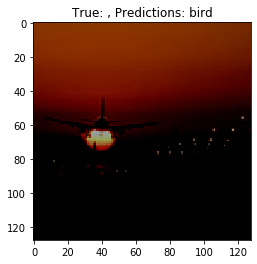

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


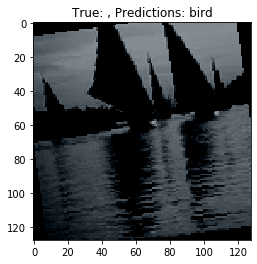

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


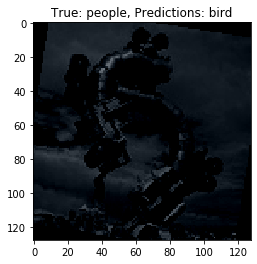

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


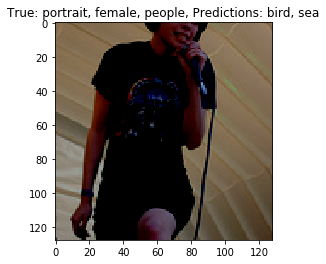

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


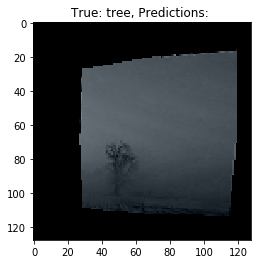

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


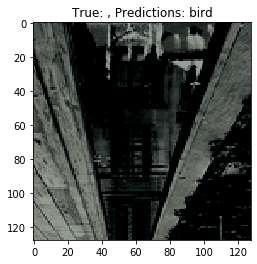

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


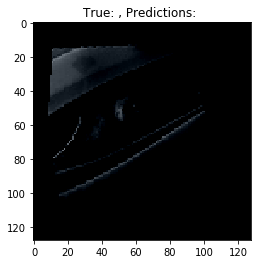

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


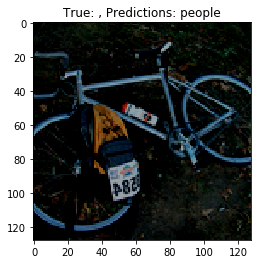

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


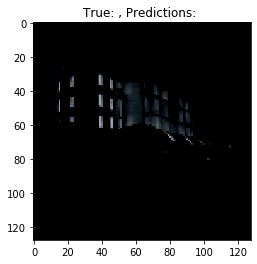

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


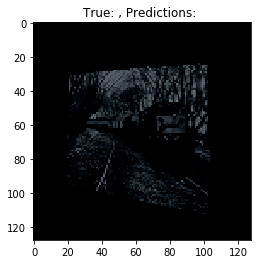

In [36]:
visualize_predictions(model, device, train_dataloader, n_to_show=10, threshold=0.75)

### Confusion matrix

In [ ]:
re_predict = True

if re_predict:

    # Predict
    y_true, y_pred = predict(model, device, valid_dataloader)
    np.save(f'../data/valid_true_labels{affix}.npy', y_true)
    np.save(f'../data/valid_pred_labels{affix}.npy', y_pred)
    
    # Save classification report
    with open(f'../data/valid_classification_report{affix}.txt', 'w') as file:
        file.write(skm.classification_report(y_true, y_pred))
    
    # Save confusion matrix plot
    labels = [k for k, v in get_class_map().items()]
    visualize_confusion_matrix(y_true, y_pred, labels, f'../data/valid_confusion_matrix{affix}.png')

In [ ]:
# Show classification report
with open(f'../data/valid_classification_report{affix}.txt', 'r') as file:
    report = ''.join(file.readlines())
    print(report)

In [ ]:
# Show confus|ion matrix plot
IPython_Image(filename=f'../data/valid_confusion_matrix{affix}.png', width=1000)